In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, integrate, special
from scipy.fftpack import fft, dct
from math import pi

In [7]:
import numba
from numba import jit
print(numba.__version__)

0.33.0


In [8]:
special.airy(3.)

(0.0065911393574607166,
 -0.011912976705951313,
 14.037328963730229,
 22.922214966382171)

In [ ]:
class SemiClassicalShcrodinger:
    
    
    def __init__(self, dx, dv, dt, ):
        

In [48]:
def Pj(p, V_j, eps):
    P = np.ones((2,2), dtype=complex)
    P[1,0] = 1j*np.sqrt(p**2 - 2*V_j)/eps
    P[1,1] = -P[1,0]
    return P

In [ ]:
def M_j():
    s_j = 
    b_j = x_j + p**2/2*s_j - V_j/s_j
    M = np.zeros((2,2), dtype=complex)
    

In [16]:
EPS = 1e-8
# Computation domain
xmin, xmax = -1.5, 1.5
vmin, vmax = -1.5, 1.5
dx, dv = 0.03, 0.03
x = np.arange(xmin-dx/2, xmax-dx/2, dx)
v = np.arange(vmin-dv/2, vmax-dv/2, dv)
# Meshgrids
X, V = np.meshgrid(x, v)

In [17]:
# Initial data
def f0(X , V):
    return (X <= 0)*(V > 0)*(X**2 + V**2 < 1) + (X >= 0)*(V < 0)*(X**2 + V**2 < 1)

In [18]:
# The exact solution at T = 1
def f1(X, V):
    return ((X >= 0)*(V < np.sqrt(0.4))*(V > X) + 
            (X >= 0)*(V < 0)*(X < 1)*(V > 0.5*(X - np.sqrt(2 - X**2))) + 
            (X <= 0)*(V < X)*(V > -np.sqrt(0.6))*(X < (1 - np.sqrt(0.6 - V**2)/np.sqrt(V**2 + 0.4))*V) + 
            (X <= 0)*(V > 0)*(X > -1)*(V < 0.5*(X + np.sqrt(2 - X**2))) + 
            (X >=0 )*(V > np.sqrt(0.4))*(V > X)*(V < np.sqrt(1.4))*(X > (1 - np.sqrt(1.4 - V**2)/np.sqrt(V**2 - 0.4))*V))

/Users/zheng/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/Users/zheng/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/Users/zheng/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/zheng/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in sqrt
/Users/zheng/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


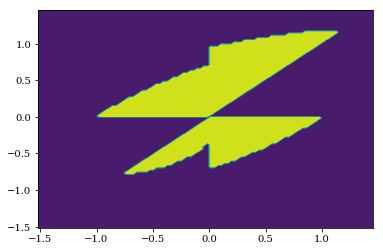

In [19]:
plt.contourf(X, V, f1(X, V))
plt.savefig('exact.pdf')

In [20]:
def s_lim(sl, sr):
    return np.tan(0.5*(np.arctan(sl) + np.arctan(sr)))

In [104]:
# Potential
def V_m(x):
    return 0.2*(x<EPS)

def V_p(x):
    return 0.2*(x<-EPS)

In [105]:
def iter(f,z):
    tmp = np.zeros(f.shape)
    for i in np.arange(2, f.shape[1]-2):
        for j in np.arange(2, f.shape[0]-2):
            if v[j] > 0:
                f_m = f[j,i] + s_lim((f[j,i]-f[j,i-1])/dx, (f[j,i+1]-f[j,i])/dx)*dx/2
                DV = V_p(x[i]-dx/2) - V_m(x[i]-dx/2)
                if np.abs(DV) < EPS:
                    f_p = f[j,i-1] + s_lim((f[j,i-1]-f[j,i-2])/dx,(f[j,i]-f[j,i-1])/dx)*dx/2
                elif v[j]**2 + 2*DV >= 0:
                    v_m = np.sqrt(v[j]**2 + 2*DV)
                    k = np.searchsorted(v, v_m, side='right') - 1
                    if k == f.shape[0]-1:
                        f_p = 0
                    else:
                        f_p = (f[k,i-1]+s_lim((f[k,i-1]-f[k,i-2])/dx,(f[k,i]-f[k,i-1])/dx)*dx/2)*(v[k+1]-v_m)/dv + \
                        (f[k+1,i-1]+s_lim((f[k+1,i-1]-f[k+1,i-2])/dx,(f[k+1,i]-f[k+1,i-1])/dx)*dx/2)*(v_m-v[k])/dv
                else:
                    k = np.searchsorted(v, -v[j])
                    f_p = f[k,i] - s_lim((f[k,i]-f[k,i-1])/dx,(f[k,i+1]-f[k,i])/dx)*dx/2
            else:
                f_p = f[j,i] - s_lim((f[j,i]-f[j,i-1])/dx, (f[j,i+1]-f[j,i])/dx)*dx/2
                DV = V_m(x[i]+dx/2) - V_p(x[i]+dx/2)
                if np.abs(DV) < EPS:
                    f_m = f[j,i+1] - s_lim((f[j,i+1]-f[j,i])/dx, (f[j,i+2]-f[j,i+1])/dx)*dx/2
                elif v[j]**2 + 2*DV >= 0:
                    v_p = -np.sqrt(v[j]**2 + 2*DV)
                    k = np.searchsorted(v, v_p, side='right') - 1
                    if k ==0:
                        f_m = 0
                    else:
                        f_m = (f[k,i+1] - s_lim((f[k,i+1]-f[k,i])/dx,(f[k,i+2]-f[k,i+1])/dx)*dx/2)*(v[k+1]-v_p)/dv + \
                        (f[k+1,i+1] - s_lim((f[k+1,i+1]-f[k+1,i])/dx,(f[k+1,i+2]-f[k+1,i+1])/dx)*dx/2)*(v_p-v[k])/dv
                else:
                    k = np.searchsorted(v, -v[j])
                    f_m = f[k,i] + s_lim((f[k,i]-f[k,i-1])/dx,(f[k,i+1]-f[k,i])/dx)*dx/2
                    
            tmp[j,i] = f[j,i] - v[j]*(f_m-f_p)*dt/dx + ((V_m(x[i]+dx/2)-V_p(x[i]-dx/2))/dx+0.1*z)*(f[j+1,i]-f[j-1,i])*dt/(2*dv) + \
                       ((V_m(x[i]+dx/2)-V_p(x[i]-dx/2))/dx+0.1*z)**2*(f[j+1,i]-2*f[j,i]+f[j-1,i])*dt**2/(2*dv**2)
                
    return tmp

In [106]:
def iter_fast(f,z):
    tmp = np.zeros(f.shape)
    fp_1 = f[2:-2,2:-2] + s_lim((f[2:-2,2:-2]-f[2:-2,1:-3])/dx, (f[2:-2,3:-1]-f[2:-2,2:-2])/dx)*dx/2
    fp_2 = f[2:-2,1:-3] + s_lim((f[2:-2,1:-3]-f[2:-2,:-4])/dx, (f[2:-2,2:-2]-f[2:-2,1:-3])/dx)*dx/2
    fm_1 = f[2:-2,3:-1] - s_lim((f[2:-2,3:-1]-f[2:-2,2:-2])/dx, (f[2:-2,4:]-f[2:-2,3:-1])/dx)*dx/2
    fm_2 = f[2:-2,2:-2] - s_lim((f[2:-2,2:-2]-f[2:-2,1:-3])/dx, (f[2:-2,3:-1]-f[2:-2,2:-2])/dx)*dx/2
    
    tmp[2:-2,2:-2] = f[2:-2,2:-2] - ((v[2:-2]>0)*v[2:-2])[:,None]*(fp_1-fp_2)*dt/dx - ((v[2:-2]<0)*v[2:-2])[:,None]*(fm_1-fm_2)*dt/dx + \
                    ((V_m(x[2:-2]+dx/2)-V_p(x[2:-2]-dx/2))/dx+0.1*z)[None,:]*(f[3:-1,2:-2]-f[1:-3,2:-2])*dt/(2*dv) + \
                    ((V_m(x[2:-2]+dx/2)-V_p(x[2:-2]-dx/2))/dx+0.1*z)[None,:]**2*(f[3:-1,2:-2]-2*f[2:-2,2:-2]+f[1:-3,2:-2])*dt**2/(2*dv**2)
    for i in (np.searchsorted(x,0)-1, np.searchsorted(x,0)):
        for j in np.arange(2, f.shape[0]-2):
            if v[j] > 0:
                f_m = f[j,i] + s_lim((f[j,i]-f[j,i-1])/dx, (f[j,i+1]-f[j,i])/dx)*dx/2
                DV = V_p(x[i]-dx/2) - V_m(x[i]-dx/2)
                if np.abs(DV) < EPS:
                    f_p = f[j,i-1] + s_lim((f[j,i-1]-f[j,i-2])/dx,(f[j,i]-f[j,i-1])/dx)*dx/2
                elif v[j]**2 + 2*DV >= 0:
                    v_m = np.sqrt(v[j]**2 + 2*DV)
                    k = np.searchsorted(v, v_m, side='right') - 1
                    if k == f.shape[0]-1:
                        f_p = 0
                    else:
                        f_p = (f[k,i-1]+s_lim((f[k,i-1]-f[k,i-2])/dx,(f[k,i]-f[k,i-1])/dx)*dx/2)*(v[k+1]-v_m)/dv + \
                        (f[k+1,i-1]+s_lim((f[k+1,i-1]-f[k+1,i-2])/dx,(f[k+1,i]-f[k+1,i-1])/dx)*dx/2)*(v_m-v[k])/dv
                else:
                    k = np.searchsorted(v, -v[j])
                    f_p = f[k,i] - s_lim((f[k,i]-f[k,i-1])/dx,(f[k,i+1]-f[k,i])/dx)*dx/2
            else:
                f_p = f[j,i] - s_lim((f[j,i]-f[j,i-1])/dx, (f[j,i+1]-f[j,i])/dx)*dx/2
                DV = V_m(x[i]+dx/2) - V_p(x[i]+dx/2)
                if np.abs(DV) < EPS:
                    f_m = f[j,i+1] - s_lim((f[j,i+1]-f[j,i])/dx, (f[j,i+2]-f[j,i+1])/dx)*dx/2
                elif v[j]**2 + 2*DV >= 0:
                    v_p = -np.sqrt(v[j]**2 + 2*DV)
                    k = np.searchsorted(v, v_p, side='right') - 1
                    if k ==0:
                        f_m = 0
                    else:
                        f_m = (f[k,i+1] - s_lim((f[k,i+1]-f[k,i])/dx,(f[k,i+2]-f[k,i+1])/dx)*dx/2)*(v[k+1]-v_p)/dv + \
                        (f[k+1,i+1] - s_lim((f[k+1,i+1]-f[k+1,i])/dx,(f[k+1,i+2]-f[k+1,i+1])/dx)*dx/2)*(v_p-v[k])/dv
                else:
                    k = np.searchsorted(v, -v[j])
                    f_m = f[k,i] + s_lim((f[k,i]-f[k,i-1])/dx,(f[k,i+1]-f[k,i])/dx)*dx/2
                    
            tmp[j,i] = f[j,i] - v[j]*(f_m-f_p)*dt/dx + ((V_m(x[i]+dx/2)-V_p(x[i]-dx/2))/dx+0.1*z)*(f[j+1,i]-f[j-1,i])*dt/(2*dv) + \
                       ((V_m(x[i]+dx/2)-V_p(x[i]-dx/2))/dx+0.1*z)**2*(f[j+1,i]-2*f[j,i]+f[j-1,i])*dt**2/(2*dv**2)
                
    return tmp

In [107]:
# z nodes and weights for numerical integral
M = 20
z, w= np.polynomial.legendre.leggauss(M)

In [110]:
# Time step
dt = 0.002
# Time stop
T = 1
# GPC order
gpc_order = 7

# Initial the function
f = np.zeros((v.shape[0],x.shape[0],gpc_order))
f[:,:,0] = np.array(f0(X, V), dtype = "float64")

P = np.zeros((gpc_order,M))
for i in np.arange(gpc_order):
    P[i,:] = np.sqrt(2*i+1)*special.eval_legendre(i,z)
    
    
tmp = np.zeros((v.shape[0],x.shape[0],M))  
for t in np.arange(0,T,dt):
    ftmp = f.dot(P)
    for i in np.arange(M):
        tmp[:,:,i] = iter_fast(ftmp[:,:,i],z[i])
        
    for k in np.arange(gpc_order):
        f[:,:,k] = 0.5*(tmp*P[k][None,None,:]).dot(w)


In [111]:
ref_mean = f[:,:,0]
ref_var = np.sqrt(np.einsum('ijk,ijk->ij',f[:,:,1:],f[:,:,1:]))

In [ ]:
# Time step
dt = 0.002
# Time stop
T = 1
# GPC order

gpc_mean = []
gpc_var = []

for gpc_order in np.arange(3,20):
    # Initial the function
    f = np.zeros((v.shape[0],x.shape[0],gpc_order))
    f[:,:,0] = np.array(f0(X, V), dtype = "float64")

    P = np.zeros((gpc_order,M))
    for i in np.arange(gpc_order):
        P[i,:] = np.sqrt(2*i+1)*special.eval_legendre(i,z)


    tmp = np.zeros((v.shape[0],x.shape[0],M))  
    for t in np.arange(0,T,dt):
        ftmp = f.dot(P)
        for i in np.arange(M):
            tmp[:,:,i] = iter_fast(ftmp[:,:,i],z[i])

        for k in np.arange(gpc_order):
            f[:,:,k] = 0.5*(tmp*P[k][None,None,:]).dot(w)
            
    
    var = np.sqrt(np.einsum('ijk,ijk->ij',f[:,:,1:],f[:,:,1:]))
    
    #gpc_mean.append(linalg.norm(vec_mean - u[0], 1) / N)
    #gpc_var.append(linalg.norm(vec_var - var, 1) / N)
    gpc_mean.append(linalg.norm((ref_mean - f[:,:,0]).flatten(),1)*dx*dv)
    gpc_var.append(linalg.norm((ref_var - var).flatten(),1)*dx*dv)


In [ ]:
line1, = plt.plot(np.arange(3,20,1),gpc_mean,'-o',label='Mean error')
line2, = plt.plot(np.arange(3,20,1),gpc_var,'-*',label='Variance error')
plt.legend(handles=[line1, line2])
plt.xlabel('gPC order',fontsize='large')
plt.ylabel('error',fontsize='large')

plt.savefig('convergence.pdf')

In [ ]:
line1, = plt.semilogy(np.arange(3,20,1),gpc_mean,'-o',label='Mean convergence error')
line2, = plt.semilogy(np.arange(3,20,1),gpc_var,'-*',label='Variance convergence error')
plt.legend(handles=[line1, line2],loc=3)
plt.title('Semilog error respect to reference solution')
plt.xlabel('gPC order',fontsize='large')
plt.ylabel('semilog error',fontsize='large')

plt.savefig('semilog_conv.pdf')

In [ ]:
line1, = plt.loglog(np.arange(3,20,1),gpc_mean,'-o',label='Mean convergence error')
line2, = plt.loglog(np.arange(3,20,1),gpc_var,'-*',label='Variance convergence error')
plt.legend(handles=[line1, line2],loc=1)
plt.title('Loglog error respect to reference solution')
plt.xlabel('gPC order',fontsize='large')
plt.ylabel('loglog error',fontsize='large')

plt.savefig('loglog_conv.pdf')

In [114]:
# Time step
dt = 0.002
# Time stop
T = 1

# Initial the function
f = np.array(f0(X, V), dtype = "float64")

fz = np.zeros((v.shape[0],x.shape[0],M))

for i in np.arange(M):
    f = np.array(f0(X, V), dtype = "float64")
    for t in np.arange(0, T, dt):
        f = iter_fast(f,z[i])
    
    fz[:,:,i] = np.copy(f) 

KeyboardInterrupt: 

In [95]:
# Time step
dt = 0.001
# Time stop
T = 1

# Initial the function
f = np.array(f0(X, V), dtype = "float64")

fz = np.zeros((v.shape[0],x.shape[0],M))


#tmp = np.zeros(f.shape)
for t in np.arange(0, T, dt):
    f = iter_fast(f,0)

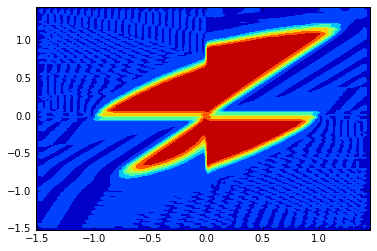

In [112]:
plt.contourf(X,V,ref_mean)
plt.savefig('mean.pdf')

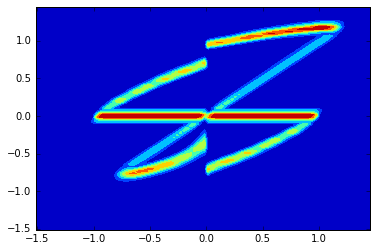

In [113]:
plt.contourf(X,V,ref_var)
plt.savefig('var.pdf')

In [71]:
1/(1.5/0.015+0.2/(0.015**2))

0.0010112359550561798

In [87]:
err50 = linalg.norm((f-f1(X,V)).flatten(),1)*0.06**2

/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in sqrt
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


In [56]:
err100

0.16506555621877422

In [73]:
err200

0.094496381625101197

In [88]:
err50

0.28798291460221398

In [118]:
r = np.load('collocation.npy')
col_mean = 0.5*r.dot(w)
col_var = np.sqrt(0.5*(r**2).dot(w)-col_mean**2)

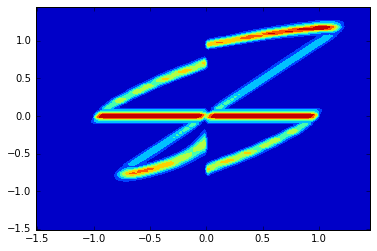

In [121]:
plt.contourf(X,V,col_var)
plt.savefig('col_var.pdf')

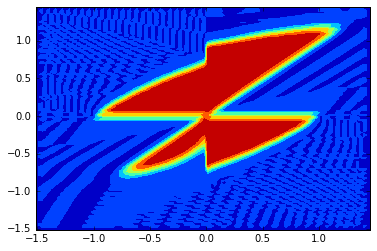

In [122]:
plt.contourf(X,V,col_mean)
plt.savefig('col_mean.pdf')

In [36]:
linalg.norm((f[:,:,0]-0.5*r.dot(w).flatten(),1)*0.03**2

5.5556084521988117e-06

In [102]:
a

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [101]:
a.dot(b)

array([[ 14,  38,  62],
       [ 86, 110, 134]])

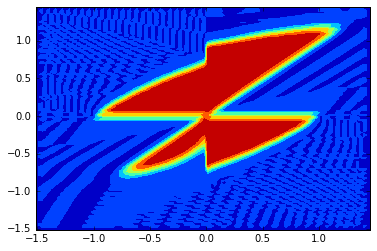

In [92]:
plt.contourf(X, V, q)

In [80]:
v[80]

0.88500000000000223

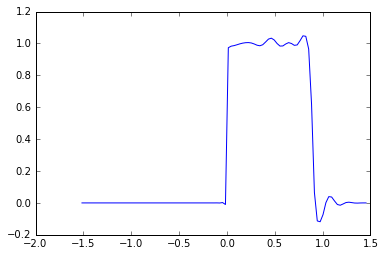

In [40]:
plt.plot(x, f[80])

In [55]:
linalg.norm((f-f1(X,V)).flatten(),1)*0.03**2

/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in sqrt
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


0.1604624860931097

In [21]:
# Time step
dt = 0.01
# Time stop
T = 1

# Initial the function
f = np.array(f0(X, V), dtype = "float64")

tmp = np.zeros(f.shape)
for t in np.arange(0, T, dt):
    for i in np.arange(1, f.shape[1]-1):
        for j in np.arange(1, f.shape[0]-1):
            if v[j] > 0:
                f_m = f[j,i]
                DV = V_p(x[i]-dx/2) - V_m(x[i]-dx/2)
                if np.abs(DV) < EPS:
                    f_p = f[j,i-1]
                elif v[j]**2 + 2*DV >= 0:
                    v_m = np.sqrt(v[j]**2 + 2*DV)
                    k = np.searchsorted(v, v_m, side='right') - 1
                    if k == f.shape[0]-1:
                        f_p = 0
                    else:
                        f_p = f[k,i-1]*(v[k+1]-v_m)/dv + f[k+1,i-1]*(v_m-v[k])/dv
                else:
                    f_p = f[np.searchsorted(v, -v[j]),i]
            else:
                f_p = f[j,i]
                DV = V_m(x[i]+dx/2) - V_p(x[i]+dx/2)
                if np.abs(DV) < EPS:
                    f_m = f[j,i+1]
                elif v[j]**2 + 2*DV >= 0:
                    v_p = -np.sqrt(v[j]**2 + 2*DV)
                    k = np.searchsorted(v, v_p, side='right') - 1
                    if k ==0:
                        f_m = 0
                    else:
                        f_m = f[k,i+1]*(v[k+1]-v_p)/dv + f[k+1,i+1]*(v_p-v[k])/dv
                else:
                    f_m = f[np.searchsorted(v, -v[j]),i]
                    
            tmp[j,i] = f[j,i] - v[j]*(f_m-f_p)*dt/dx + (V_m(x[i]+dx/2)-V_p(x[i]-dx/2)>0)*(V_m(x[i]+dx/2)-V_p(x[i]-dx/2))*(f[j+1,i]-f[j,i])*dt/(dx*dv) \
                    + (V_m(x[i]+dx/2)-V_p(x[i]-dx/2)<0)*(V_m(x[i]+dx/2)-V_p(x[i]-dx/2))*(f[j,i]-f[j-1,i])*dt/(dx*dv)
    
    f[:,:] = tmp[:,:]

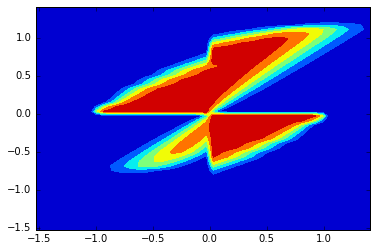

In [23]:
plt.contourf(X, V, f)

In [91]:
linalg.norm((f-f1(X,V)).flatten(),1)

/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in sqrt
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in sqrt
/Users/zheng/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


0.32439332273119514

In [ ]:
# Time step
dt = 0.01
# Time stop
T = 1

# Initial the function
f = np.array(f0(X, V), dtype = "float64")

for j in np.arange(f.shape[1]):
    for i in np.arange(f.shape[0]):
        if v[i] > 0:
            rows_m[i,j], cols_m[i,j] = i, j
            DV = V_p(x[j]+dx/2) - V_m(x[j]+dx/2)
            if v[i]**2 + 2*DV >= 0:
                v_m = np.sqrt(v[i]**2 + 2*DV)
                rows_p[i,j], cols_p[i,j] = np.searchsorted(v, v_m), j
            else:
                rows_p[i,j], cols_p[i,j] = np.searchsorted(v, -v[i]), j
        else:
            rows_p[i,j], cols_p[i,j] = i, j
            
            
            

# Iteration
for t in np.arange(0, T, dt):
    f[:,:] = f[:,:] - V*(f[rows_m, cols_m]-f[rows_p, cols_p])/dx  + \
            (P(X+0.5*dx-EPS)-P(X-0.5*dx+EPS)>0)*P(X+0.5*dx-EPS)-P(X-0.5*dx+EPS)*(f[:,:]-f[:,]) + \
            (P(X+0.5*dx-EPS)-P(X-0.5*dx+EPS)<0)*P(X+0.5*dx-EPS)-P(X-0.5*dx+EPS)*(f[:,:]-f[:,])     